In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go # For the waterfall plot -- cannot easily do this in matplotlib
from typing import List, Dict, Tuple, Any

# Explainable Boosting Machine from Microsoft to help automate some of the initial data exploration
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show

%load_ext kedro.ipython
%matplotlib inline

[08/01/24 22:11:55] INFO     Registered line magic '%reload_kedro'                                   ]8;id=110590;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=398407;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\ipython\__init__.py#58\58]8;;\

                    INFO     Registered line magic '%load_node'                                      ]8;id=664694;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=839457;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\ipython\__init__.py#60\60]8;;\

                    INFO     Resolved project path as:                                              ]8;id=198016;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=937521;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\ipython\__init__.py#171\171]8;;\
                             c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_r                
                             ating_predictions\goodreads-predictor.                                                
                             To set a different path, run '%reload_kedro <project_root>'                           

[08/01/24 22:11:58] INFO     Kedro project goodreads-predictor                                      ]8;id=854519;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=169957;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\ipython\__init__.py#141\141]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=591946;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=539502;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\ipython\__init__.py#142\142]8;;\
                             'pipelines'                                                                           

[08/01/24 22:12:00] INFO     Registered line magic 'run_viz'                                        ]8;id=781290;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=176335;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\ipython\__init__.py#148\148]8;;\

In [3]:
context.catalog.list()


[
    'books_raw',
    'books_loaded',
    'publisher_consolidation',
    'price_by_isbn_input',
    'price_by_isbn',
    'book_genres',
    'title_embeddings_original',
    'authors_embeddings',
    'description_embeddings',
    'open_library_book_api_info_input',
    'open_library_book_api_info',
    'filtered_books',
    'exclusions_summary',
    'scope_waterfall_plot',
    'parameters',
    'params:title_column',
    'params:author_column',
    'params:description_column',
    'params:original_data_key_column',
    'params:color_gr_brown',
    'params:color_gr_purple',
    'params:color_gr_green',
    'params:color_gr_tan_background'
]

In [4]:
books_input = catalog.load('books_loaded')
price_by_isbn = catalog.load('price_by_isbn')
title_embeddings = catalog.load('title_embeddings_original')
book_api_data = catalog.load('open_library_book_api_info')

# Get the color values
color_gr_brown = catalog.load("params:color_gr_brown")
color_gr_purple = catalog.load("params:color_gr_purple")
color_gr_green = catalog.load("params:color_gr_green")
color_gr_tan_background = catalog.load("params:color_gr_tan_background")

# Add in the price data
books_input = books_input.merge(price_by_isbn, on='isbn13', how='left')

                    INFO     Loading data from books_loaded (ParquetDataset)...                 ]8;id=69788;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=995916;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\io\data_catalog.py#508\508]8;;\

                    INFO     Loading data from price_by_isbn (ParquetDataset)...                ]8;id=427332;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=264026;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\io\data_catalog.py#508\508]8;;\

[08/01/24 22:12:01] INFO     Loading data from title_embeddings_original (ParquetDataset)...    ]8;id=99218;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=402975;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\io\data_catalog.py#508\508]8;;\

                    INFO     Loading data from open_library_book_api_info (PickleDataset)...    ]8;id=586403;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=765890;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\io\data_catalog.py#508\508]8;;\

                    INFO     Loading data from params:color_gr_brown (MemoryDataset)...         ]8;id=844828;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=932855;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\io\data_catalog.py#508\508]8;;\

                    INFO     Loading data from params:color_gr_purple (MemoryDataset)...        ]8;id=568469;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=256385;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\io\data_catalog.py#508\508]8;;\

                    INFO     Loading data from params:color_gr_green (MemoryDataset)...         ]8;id=513046;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=731281;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\io\data_catalog.py#508\508]8;;\

                    INFO     Loading data from params:color_gr_tan_background                   ]8;id=49106;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=39195;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\io\data_catalog.py#508\508]8;;\
                             (MemoryDataset)...                                                                    

In [5]:
print(books_input.shape)
print(books_input.columns)
books_input.head()

(11123, 14)
Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher', 'Price', 'PriceStrategy'],
      dtype='object')


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,Price,PriceStrategy
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,12.99,LIST_PRICE
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.,99.99,LIST_PRICE
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,24.95,LIST_PRICE
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.,7.99,LIST_PRICE
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic,40.95,LIST_PRICE


# Data Explore

## Quantitative Features

<Axes: >

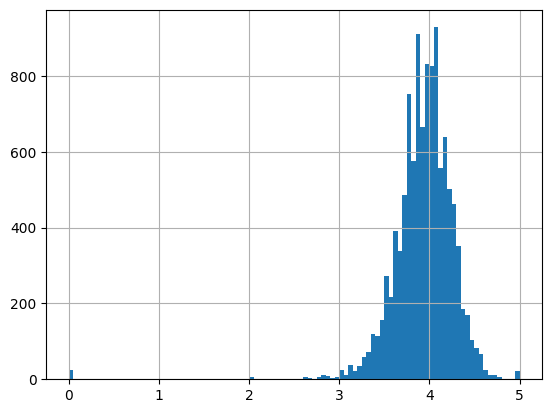

In [6]:
# Basic plots of the data to identify potential filters to remove poor quality data
books_input['average_rating'].hist(bins=100)

<Axes: >

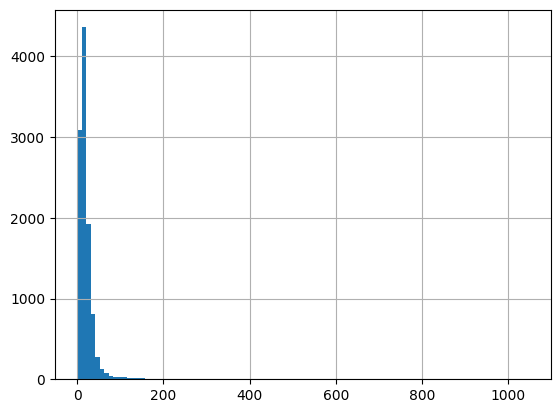

In [7]:
books_input[books_input['Price'] > 0]['Price'].hist(bins=100)

<Axes: >

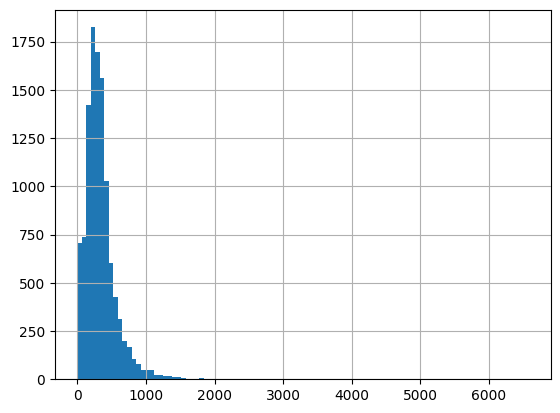

In [8]:
books_input['  num_pages'].hist(bins=100)

<Axes: >

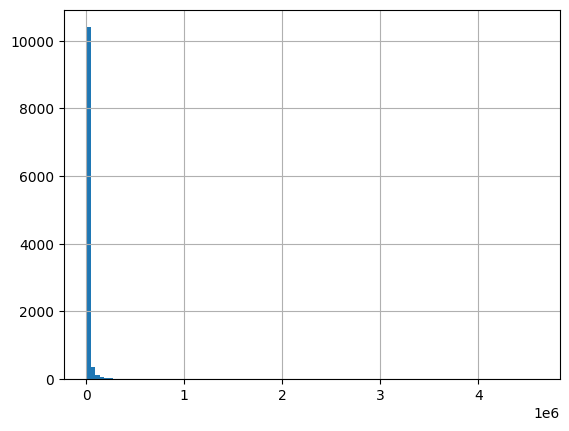

In [9]:
books_input['ratings_count'].hist(bins=100)

In [10]:
books_input[['ratings_count']].describe()

,ratings_count
count,1.112300e+04
mean,1.794285e+04
std,1.124992e+05
min,0.000000e+00
25%,1.040000e+02
50%,7.450000e+02
75%,5.000500e+03
max,4.597666e+06


<Axes: >

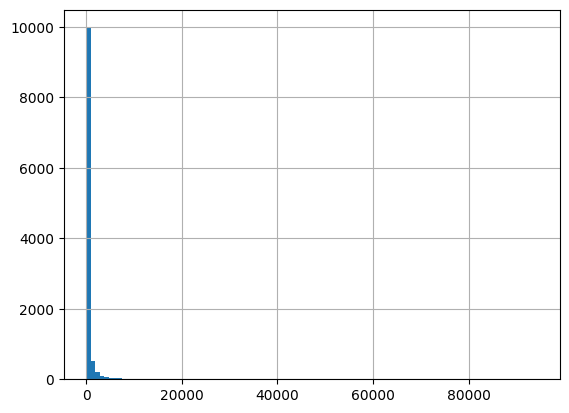

In [11]:
books_input['text_reviews_count'].hist(bins=100)


## Qualitative Features

In [12]:
## We'll add a factor lumping component to the data to help with the model
# Should also clean up the different language codes

In [13]:
books_input.groupby('language_code').agg(
    Ct = ('bookID', 'count'),
    AvgRating = ('average_rating', 'mean'),
    MedianRating = ('average_rating', 'median'),
    DeviationRating = ('average_rating', 'std')
).sort_values('Ct', ascending=False)

,Ct,AvgRating,MedianRating,DeviationRating
language_code,,,,
eng,8908,3.934062,3.960,0.358838
en-US,1408,3.914659,3.940,0.288971
spa,218,3.929312,3.950,0.270195
en-GB,214,3.923411,3.945,0.278563
fre,144,3.971528,3.965,0.266170
ger,99,3.950101,3.940,0.265151
jpn,46,4.268696,4.270,0.165417
mul,19,4.126316,4.190,0.254825
zho,14,4.456429,4.555,0.218442


In [14]:
books_input.groupby('publisher').agg(
    Ct = ('bookID', 'count'),
    AvgRating = ('average_rating', 'mean'),
    MedianRating = ('average_rating', 'median'),
    DeviationRating = ('average_rating', 'std')
).sort_values('Ct', ascending=False)

,Ct,AvgRating,MedianRating,DeviationRating
publisher,,,,
Vintage,318,3.894182,3.910,0.259305
Penguin Books,261,3.920383,3.940,0.245104
Penguin Classics,184,3.944565,3.955,0.213139
Mariner Books,150,3.933533,3.920,0.300278
Ballantine Books,144,3.875000,3.910,0.293984
...,...,...,...,...
AA World Services,1,4.450000,4.450,NaN
ACE,1,3.560000,3.560,NaN
AHA! Process,1,3.900000,3.900,NaN


In [15]:
books_input.groupby('authors').agg(
    Ct = ('bookID', 'count'),
    AvgRating = ('average_rating', 'mean'),
    MedianRating = ('average_rating', 'median'),
    DeviationRating = ('average_rating', 'std')
).sort_values('Ct', ascending=False)

,Ct,AvgRating,MedianRating,DeviationRating
authors,,,,
P.G. Wodehouse,40,4.147250,4.165,0.158422
Stephen King,40,3.973500,3.965,0.270067
Rumiko Takahashi,39,4.186667,4.230,0.114141
Orson Scott Card,35,3.779143,3.840,0.262436
Agatha Christie,33,3.989091,3.970,0.188884
...,...,...,...,...
Émile Zola/Henri Mitterand,1,4.060000,4.060,NaN
Émile Zola/Robert Lethbridge/Elinor Dorday,1,4.010000,4.010,NaN
Émile Zola/Robin Buss/Brian Nelson,1,3.990000,3.990,NaN


# Create the data processing steps

In [16]:
def identify_most_common_author_by_isbn(books_input: pd.DataFrame) -> pd.DataFrame:
    """
    Identify the most common author for each book title in the dataset.

    Args:
        books_input (pd.DataFrame): The input DataFrame containing book information.

    Returns:
        pd.DataFrame: A DataFrame with the most common author for each book title, indexed by ISBN.
    """
    # Identify how often authors are represented in the dataset overall
    author_frequency = (
        books_input[['isbn13', 'authors']]
        .assign(authors_list = lambda x: x['authors'].str.split('/'))
        .explode('authors_list')
        .assign(authors_list = lambda x: x['authors_list'].str.strip())
        .groupby('authors_list')
        .agg(
            Ct = ('isbn13', 'nunique')
        )
        .sort_values('Ct', ascending=False)
    )

    # Figure out which author is most common by ISBN
    most_common_author_by_isbn = (
        books_input[['isbn13', 'authors']]
        .assign(authors_list = lambda x: x['authors'].str.split('/'))
        .explode('authors_list')
        .assign(authors_list = lambda x: x['authors_list'].str.strip())
        .merge(author_frequency, left_on='authors_list', right_index=True, validate='m:1')
        .sort_values(['Ct', 'authors_list'], ascending=False)
        .groupby('isbn13')
        .agg(
            most_common_author = ('authors_list', 'first')
        )
    )

    return most_common_author_by_isbn

In [17]:
def consolidate_duplicated_titles(data: pd.DataFrame) -> pd.DataFrame:
    """
    Consolidates duplicated titles in the given DataFrame.

    Args:
        data (pd.DataFrame): The DataFrame containing the data to be consolidated.

    Returns:
        pd.DataFrame: The consolidated DataFrame with duplicated titles removed and aggregated values.

    """
    # Identify the proper description to grab
    longest_descriptions_by_title = (
        data
        .assign(DescriptionLength = lambda x: x['Description'].str.len())
        .sort_values('DescriptionLength', ascending = False)
        .groupby('title')
        .agg(
            LongestDescription = ('Description', 'first')
        )
    )

    # Aggregate at each unique title
    return (
        data
        .merge(longest_descriptions_by_title, left_on='title', right_index = True, how='left')
        .sort_values('ratings_count', ascending = False)
        .groupby('title')
        .apply(lambda g: pd.Series({
            'isbn': g['isbn'].values[0],
            'isbn13': g['isbn13'].values[0],
            'most_common_author': g['most_common_author'].mode().values[0],
            'average_rating': (g['average_rating'] * g['ratings_count']).sum() / g['ratings_count'].sum(),
            'num_pages': g['  num_pages'].mean(),
            'ratings_count': g['ratings_count'].sum(),
            'text_reviews_count': g['text_reviews_count'].sum(),
            'publisher': g['publisher'].mode().values[0],
            'Price': g[g['Price'] > 0]['Price'].mean(),
            'language_code': g['language_code'].mode().values[0],
            'Description': g['LongestDescription'].values[0],
        }), include_groups = False)
        .assign(Price = lambda x: x['Price'].fillna(-999))
        .reset_index(drop = False)
    )

In [18]:
def get_description_from_json(record) -> str:
    """
    Get the description from the JSON record.

    Args:
        record (Dict[str, Any]): The JSON record.

    Returns:
        str: The description of the book.
    """
    description = 'No Description Found'
    if 'description' in record.keys():
        description = record['description']

        # Check if it is a dictionary
        if type(description) == dict:
            description = description.get('value', 'No Description Found')
    elif record.get('isbn_description', []) != []:
        description = record['isbn_description']
    
        if type(description) == dict:
            description = description.get('value', 'No Description Found')
    elif 'subjects' in record.keys():
        description = ', '.join(record['subjects'])
    elif record.get('isbn_subjects', []) != []:
        description = ', '.join(record['isbn_subjects'])

    description = re.sub('[^A-z0-9\.!\?,]', ' ', description).lower()
    description = re.sub('\s+', ' ', description).strip()

    return description

In [19]:
def create_descriptions_lookup(book_api_data: List[Dict[str, Any]]) -> pd.DataFrame:
    """
    Create a lookup table for book descriptions based on book API data.

    Args:
        book_api_data (List[Dict[str, Any]]): A list of dictionaries containing book API data.

    Returns:
        pd.DataFrame: A DataFrame with two columns: 'isbn13' and 'Description'.
                     The 'isbn13' column contains the ISBN-13 numbers of the books,
                     and the 'Description' column contains the corresponding book descriptions.
    """
    descs = [get_description_from_json(x) for x in book_api_data]
    descriptions_by_isbn = pd.DataFrame({
        'isbn13': [x.get('isbn13', 'No ISBN') for x in book_api_data],
        'Description': descs
    })

    return descriptions_by_isbn

In [20]:
def create_data_filters(input_df: pd.DataFrame) -> pd.DataFrame:
    """
    Create data filters based on specific conditions in the input dataframe.

    Args:
        input_df (pd.DataFrame): The input dataframe containing the data to filter.

    Returns:
        pd.DataFrame: The filtered dataframe with an additional column indicating the filter reason.
    """

    # Initialize the series to hold the filters
    filt_num = 1
    input_df['data_filter_reason'] = 'Start - No Filter'
 
    # No ratings or pages
    input_df.loc[(input_df['ratings_count'] <= 0) & (input_df['data_filter_reason'] == 'Start - No Filter'),
     'data_filter_reason'] = f'{filt_num} - No Ratings Count'
    filt_num += 1

    input_df.loc[(input_df['  num_pages'] <= 0) & (input_df['data_filter_reason'] == 'Start - No Filter'),
     'data_filter_reason'] = f'{filt_num} - Zero Page Count'
    filt_num += 1

    # Extreme tails of the avg_ratings (looked at histogram to determine values)
    input_df.loc[(input_df['average_rating'] < 3) & (input_df['data_filter_reason'] == 'Start - No Filter'),
     'data_filter_reason'] = f'{filt_num} - Low Rating Outlier'
    filt_num += 1

    input_df.loc[(input_df['average_rating'] >4.95) & (input_df['data_filter_reason'] == 'Start - No Filter'),
     'data_filter_reason'] = f'{filt_num} - High Rating Outlier'
    filt_num += 1

    # Duplicated titles
    input_df = (
        input_df
        .merge(
            input_df.groupby('title').agg(
                isbn13 = ('isbn13', 'first')
            ).rename(columns={'isbn13': 'isbn13_grouped'}),
            left_on='title', right_index=True, how = 'left', validate = "m:1"
            )
        .assign(non_duplicate = lambda X: X['isbn13'] == X['isbn13_grouped'])
    )
    input_df.loc[(input_df['non_duplicate'] == False) & (input_df['data_filter_reason'] == 'Start - No Filter'),
                  'data_filter_reason'] = f'{filt_num} - Duplicate Title'
    filt_num += 1

    # No description
    input_df.loc[(input_df['Description'] == 'no description found') & (input_df['data_filter_reason'] == 'Start - No Filter'),
                 'data_filter_reason'] = f'{filt_num} - No Description'
    filt_num += 1

    # Final data -- what's not filtered (we want this to be last for the waterfall chart)
    input_df.loc[input_df['data_filter_reason'] == 'Start - No Filter', 'data_filter_reason'] = f'{filt_num} - Included in Model'
    
    return input_df

In [21]:
def aggregate_exclusions_data(inputs_filters: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate the exclusion data based on the input filters.

    Args:
        inputs_filters (pd.DataFrame): The input filters dataframe.

    Returns:
        filters_agg (pd.DataFrame): The aggregated exclusion data at the reason level.
        walk_data (pd.DataFrame): The walk data showing the count of books excluded for each reason.
    """
    # Aggregate at the exclusion reason level and get a count of the books excluded for each reason
    filters_agg = inputs_filters.groupby('data_filter_reason', as_index=False).agg(
        Ct = ('bookID', 'count')
    )

    # Append the add data field to create a walk from starting input to final filtered dataset
    walk_data = pd.concat([pd.DataFrame({'data_filter_reason': 'All Data', 'Ct': filters_agg['Ct'].sum()}, index = [0]), filters_agg], axis = 0).reset_index(drop=True)
    walk_data['Ct'] = np.where((walk_data.index > 0) & (walk_data.index < walk_data.index.max()),  walk_data['Ct'] * -1, walk_data['Ct'])

    return filters_agg, walk_data

In [22]:
def create_filters_waterfall_plot(walk_data: pd.DataFrame,
                                  decreasing_color: str,
                                  increasing_color: str,
                                  totals_color: str,
                                  background_color: str) -> go.Figure:
    """
    Create a waterfall plot based on the provided data.

    Args:
        walk_data (pd.DataFrame): The data used to create the waterfall plot.
        decreasing_color (str): The color for the decreasing values in the plot.
        increasing_color (str): The color for the increasing values in the plot.
        totals_color (str): The color for the total values in the plot.
        background_color (str): The background color of the plot.

    Returns:
        go.Figure: The created waterfall plot.
    """
    
    # Create dynamic fields based on data for the waterfall plot
    dynamic_measures = np.where((walk_data.index > 0) & (walk_data.index < walk_data.index.max()),  'relative', 'absolute')

    text_values = np.where(walk_data['Ct'].values > 1000,
                            [x + ' k' for x in (walk_data['Ct'].values / 1000).round(1).astype(str)],
                            walk_data['Ct'].astype(str).values)

    # Create the waterfall plot base using the data
    fig = go.Figure(go.Waterfall(
        name='Goodreads Ratings Prediction Model Data Exclusions',
        orientation='v',
        measure=dynamic_measures,
        x=walk_data['data_filter_reason'].values,
        textposition='outside',
        text=text_values,
        y=walk_data['Ct'].values,
        connector=dict(line=dict(color='rgb(63, 63, 63)')),
        decreasing=dict(marker=dict(color=decreasing_color)),
        increasing=dict(marker=dict(color=increasing_color)),
        totals=dict(marker=dict(color=totals_color))
    ))

    # Update the styling of the plot
    fig.update_layout(
        font_family = 'Helvetica',
        title='Goodreads Ratings Prediction Model Scope Walk',
        title_x=0.5,
        showlegend=False,
        plot_bgcolor=background_color,
        title_font_family='Lato',
        title_font_size=20
    )
    
    # Update axis titles and styling
    fig.update_yaxes(range=[-1,walk_data['Ct'].values.max() * 1.1], title_text='Number of Records', title_font_family='Lato')
    fig.update_xaxes(title_text='Data Filter Reason', title_font_family='Lato')

    return fig

In [23]:
decreasing_color = color_gr_purple
increasing_color = color_gr_green
totals_color = color_gr_brown
background_color = color_gr_tan_background


descriptions_lookup = create_descriptions_lookup(book_api_data)
books_with_descriptions = books_input.merge(descriptions_lookup, on='isbn13', how='left', validate = "1:1")
books_filters = create_data_filters(books_with_descriptions)
filters_agg, walk_data = aggregate_exclusions_data(books_filters)
waterfall_plot = create_filters_waterfall_plot(walk_data, decreasing_color, increasing_color, totals_color, background_color)

In [24]:
waterfall_plot.show()

In [25]:
def apply_filters_and_consolidate(books_filters: pd.DataFrame) -> pd.DataFrame:
    # Apply the filters and consolidate duplicated titles
    books_filtered = books_filters[(books_filters['data_filter_reason'].str.contains('Included in Model')) |
                                (books_filters['data_filter_reason'].str.contains('Duplicate Title'))]

    books_filtered = books_filtered.merge(identify_most_common_author_by_isbn(books_filtered), left_on='isbn13', right_index=True, how='left')
    books_filtered = consolidate_duplicated_titles(books_filtered)
    return books_filtered

In [26]:
books_filtered = apply_filters_and_consolidate(books_filters)
publishers = catalog.load('publisher_consolidation')

books_filtered = books_filtered.merge(publishers, on='publisher', how='left')
books_filtered['publisher_grouped'] = np.where(books_filtered['publisher_grouped'].isnull(),
                                               books_filtered['publisher'], books_filtered['publisher_grouped'])

[08/01/24 22:12:17] INFO     Loading data from publisher_consolidation (CSVDataset)...          ]8;id=816465;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=171620;file://c:\Users\benab\AppData\Local\GitHubDesktop\app-3.3.12\dsti_goodreads_rating_predictions\.venv\Lib\site-packages\kedro\io\data_catalog.py#508\508]8;;\

# Explainable AI (Microsoft EBM Regressor)

In [27]:
def fct_lump(data: pd.DataFrame, col: str, threshold: int, top_n: bool = False) -> pd.DataFrame:
    """
    Lump the data in the given column based on the threshold.

    Args:
        data (pd.DataFrame): The input DataFrame.
        col (str): The column to lump.
        threshold (int): The threshold to use for lumping.

    Returns:
        pd.DataFrame: The DataFrame with the column lumped based on the threshold.
    """
    # Get the value counts for the column
    value_counts = data[col].value_counts()

    # Get the values to lump
    if top_n:
        to_lump_amt = len(value_counts) - threshold
        to_lump = value_counts.nsmallest(to_lump_amt).index
    else:
        to_lump = value_counts[value_counts < threshold].index

    # Lump the values
    data.loc[:, col] = np.where(data[col].isin(to_lump), 'Other', data[col])

    return data

In [28]:
FEATURES = ['most_common_author', 'num_pages', 'ratings_count', 'text_reviews_count', 'Price', 'publisher_grouped']
TARGET = 'average_rating'

X = books_filtered[FEATURES]

for col in X.select_dtypes('object').columns:
    X = fct_lump(X, col, 20, top_n = True)

In [29]:
model = ExplainableBoostingRegressor(random_state=42)
model.fit(X, books_filtered[TARGET])

ExplainableBoostingRegressor()

In [30]:
# Base R^2 score
model.score(X, books_filtered[TARGET])

0.21292598885914815

In [31]:
show(model.explain_global())

<!-- http://127.0.0.1:7001/2306213705680/ -->